In [2]:
#The organization of this class definition is inspired by some OOP-flavored code I found at
#https://thenewphalls.wordpress.com/2014/02/19/understanding-object-oriented-programming-in-julia-part-1/

type NeuralNet     #create by e.g. "net = NeuralNet([42 100 100 1])"
                   # would one output node, 42 input nodes, and two hidden layers of 100 nodes each
    
    layers;        #an integer containing the number of hidden layers + 1
    nodes;         #an array containing the size of the net as described above
    weights;       #an array of matrices containing the weights from one layer of the net to the next
    biases;        #an array of vectors containing the bias/threshold that influences a node's activation
    
    function NeuralNet(nodes)               #constructor
        
        this = new();                       #create object
        this.nodes = nodes;                 #store node size information in the object
        
        this.layers = size(nodes)[2] - 1;   #figure out how many layers from the constructor's input
        
        this.weights = Array[];             #initialize
        this.biases = Array[];
        
        for i = 1:this.layers
            
            push!(this.weights, 0.1*rand(nodes[i+1], nodes[i]));
                                            #create weight matrices
                                            #this will result in an array of matrices
            push!(this.biases, 0.01*rand(nodes[i+1],1));
                                            #create bias vectors (as columns)
        end;
        
        return this;
    end;
end;

function Activate(x)                    #this function will be applied to the weighted sum of the inputs
                                        # before the value is passed on to the next layer
    
    #return max(0,x);                    #Rectified Linear Units aka ramp function
    return 1 ./ (1 + exp(-x));           #use logistic function instead
    
end;

function GradActivate(x)                #gradient of the activation function at x
    
    #return 1*(x.> 0);                    #returns a subgradient of ramp
    f = Activate(x); return f.*(1-f);     #gradient of logistic function
    
end;

function FeedForward(net, input; p = 0.5)
    
    x = input;

    for i = 1:net.layers-1                                      #for every layer
        
        x = Activate(p*net.weights[i]*x .+ net.biases[i]);       #weighted sum and apply activation function
        
    end;
    
    x = Activate(net.weights[net.layers]*x .+ net.biases[net.layers])    #do not bump the output layer
    
    return x';

end;

function BackPropogate(net, input, label; p = 0.5)

    alpha = 1.5/net.layers;
    alpha_bias = alpha/10;
    
    #FEED FORWARD FIRST
    
    x = Array[];                           #x will contain the pre-activated values
    
    y = Array[input];                      #y will contain the activated values

    for i = 1:net.layers-1                   #for every layer
        
        dropout = (rand(size(net.weights[i])[1]) .< p);
        
        push!(x, net.weights[i]*y[i] + net.biases[i]);     #weighted sum
        
        push!(y, dropout .* Activate(x[i]));        #activated value
        
    end;
    
    #don't dropout the outputs
    
    push!(x, net.weights[net.layers]*y[net.layers] + net.biases[net.layers]);     #weighted sum
        
    push!(y, Activate(x[net.layers]));        #activated value
    
    #NOW PERFORM GRADIENT DESCENT
    
    error = vec((label - y[net.layers+1]) .* GradActivate(x[net.layers]));    #for gradient descent
    
    net.weights[net.layers] += alpha * error * y[net.layers]';                #adjust the weights at top level
    
    net.biases[net.layers] += alpha_bias * error;                                  #biases too
    
    for i = net.layers-1:-1:1                         #reverse order
        
        error = vec((net.weights[i+1]' * error));     #percolate remaining error to next level
        
        error = error .* GradActivate(x[i])           #error propogates to next layer
        
        net.weights[i] += alpha * error * y[i]';      #adjust the weights at this level
        
        net.biases[i] += alpha_bias * error;               #biases too
        
    end;
    
    #no return value -- all corrections are made in the net since it is passed by reference
    
end;

In [3]:
function Normalize(y)
    y = y .- minimum(y,1);
    y = y ./ (maximum(y,1));
end;

function Train(net, U_train, U_test, y_train, y_test; ITS = 1000, p = 0.5)
    y_train = Normalize(y_train);
    y_test = Normalize(y_test);
    U_train = Normalize(U_train);
    U_test = Normalize(U_test);

    n = size(U_train)[1];

    rd = rand(1:n, ITS, 1);

    for i = 1:ITS
        r = rd[i];
        BackPropogate(net, U_train[r, :]', y_train[r]; p = p)
    end;

    #train_cost = 0.5*norm(FeedForward(net, U_train'; p = p) - y_train)^2;
    #test_cost = 0.5*norm(FeedForward(net, U_test'; p = p) - y_test)^2;
    
    train_correct = ones(1,n)*((FeedForward(net, U_train'; p = p) .> 0.5) .== 1*(y_train .> 0.5));
    train_correct = 100*train_correct[1,1]/n;
    test_correct = ones(1,size(U_test)[1])*((FeedForward(net, U_test'; p = p) .> 0.5) .== (y_test .> 0.5));
    test_correct = 100*test_correct[1,1]/size(U_test)[1];

    return (train_correct, test_correct);
end;

In [4]:
net1 = NeuralNet([2 15 1]);

In [5]:
#XOR TRAINING -- there is a lot of symmetry in this problem so it is difficult to train

#y = [0.07; 1.0; 0.97; 0.92];        #labels -- perturbations are included to break symmetry

y = [0.0; 1.0; 1.0; 0.0];          #true labels
U = [0 0; 0 1; 1 0; 1 1];          #training data

(train_correct, _) = Train(net1, U, U, y, y; ITS = 1000, p = 1.0)

println("% Correct = ", train_correct);

sleep(0.1);

% Correct = 50.0


In [82]:
#This experiment is going to test how many training iterations it takes in order to train an XOR net
# with the hopes of determining something about how the number of hidden nodes and dropout rate contribute

y = [0.0; 1.0; 1.0; 0.0];          #true labels
U = [0 0; 0 1; 1 0; 1 1];          #training data

U = [U U U U];                       #a simple way of reducing the dropout in the input layer -- duplicate inputs

MAX_TRIES = 100;                   #going to cap these trials at 1e4 training its
ITS_PER = 100;

AVERAGE_OVER = 10;                 #average the results each over 10 trials

data = Array[];

MIN_NODES = 5;                     #minimum architecture to try

i = 0;
for n = 10:-1:MIN_NODES
    i += 1;
    
    push!(data,[n 0]);
    for p = 1.0:-0.05:0.5
        
        total = 0;
        
        for k = 1:AVERAGE_OVER
            attempts = 0;
    
            netT = NeuralNet([8 n 1]);

            train_correct = 0;
    
            while (train_correct < 100 && attempts < MAX_TRIES)
                attempts += 1;
                (train_correct, _) = Train(netT, U, U, y, y; ITS = ITS_PER, p = p);
            end
            
            total += attempts*ITS_PER/AVERAGE_OVER;
        end

        println(total, " iterations for n = ", n, " and p = ", p);
        
        data[i] = [data[i]; p total];
    end
end

sleep(0.1);

1420.0 iterations for n = 10 and p = 1.0
1330.0 iterations for n = 10 and p = 0.95
1430.0 iterations for n = 10 and p = 0.9
1740.0 iterations for n = 10 and p = 0.85
1700.0 iterations for n = 10 and p = 0.8
2290.0 iterations for n = 10 and p = 0.75
2200.0 iterations for n = 10 and p = 0.7
2550.0 iterations for n = 10 and p = 0.65
2810.0 iterations for n = 10 and p = 0.6
3700.0 iterations for n = 10 and p = 0.55
4660.0 iterations for n = 10 and p = 0.5
1530.0 iterations for n = 9 and p = 1.0
1330.0 iterations for n = 9 and p = 0.95
1240.0 iterations for n = 9 and p = 0.9
1630.0 iterations for n = 9 and p = 0.85
1860.0 iterations for n = 9 and p = 0.8
2170.0 iterations for n = 9 and p = 0.75
2380.0 iterations for n = 9 and p = 0.7
2660.0 iterations for n = 9 and p = 0.65
4310.0 iterations for n = 9 and p = 0.6
4770.0 iterations for n = 9 and p = 0.55
5230.0 iterations for n = 9 and p = 0.5
1520.0 iterations for n = 8 and p = 1.0
1380.0 iterations for n = 8 and p = 0.95
1320.0 iterations 

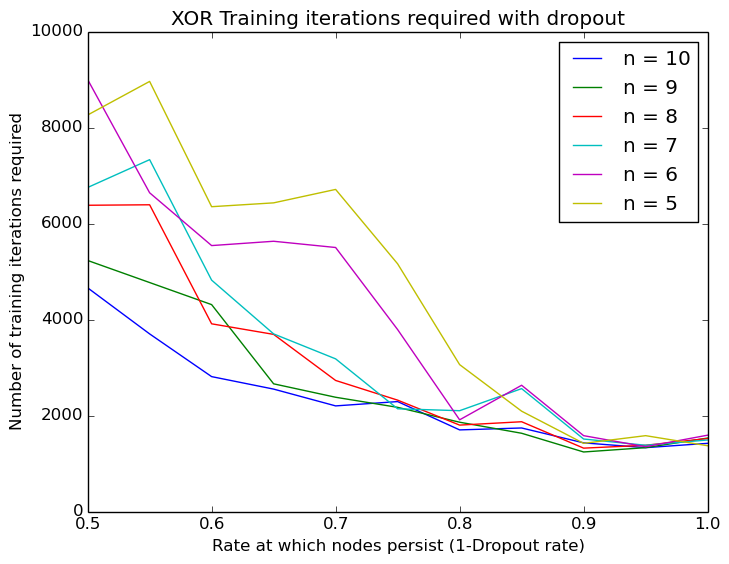

In [90]:
using PyPlot

figure();
xlabel("Rate at which nodes persist (1-Dropout rate)");
ylabel("Number of training iterations required");
title("XOR Training iterations required with dropout");

i = 1;
for i = 1:11-MIN_NODES;
    n = round(Int64,(data[i])[1,1])
    plot((data[i])[2:end,1], (data[i])[2:end,2], label= string("n = ", n));
end

legend(loc="top right");

axis([0.5; 1.0; 0; 1e4]);

show();

sleep(0.1);

In [74]:
net4 = NeuralNet([1 15 15 1]);

In [75]:
#SIN TRAINING

U_train = (0:0.01:1.5)'';
y_train = sin(U_train);

U_test = (0.05:0.01:1.55)'';
y_test = sin(U_test);

n = size(U_train)[1];

In [78]:
ITS = 1000000;
p = 0.5;

rd = rand(1:n, ITS, 1);

for i = 1:ITS
    r = rd[i];
    BackPropogate(net4, U_train[r, :]', y_train[r]; p = p)
end;

train_cost = 0.5*norm(FeedForward(net4, U_train'; p = p) - y_train)^2;
test_cost = 0.5*norm(FeedForward(net4, U_test'; p = p) - y_test)^2;
    
println("Train Cost: ", train_cost);
println("Test Cost: ", test_cost);

Train Cost: 1.449505325171569
Test Cost: 1.2395126070029128


In [104]:
FeedForward(net4, U_test'; p = p) - y_test

151x1 Array{Float64,2}:
  0.0535829 
  0.0479565 
  0.0424967 
  0.0372081 
  0.032095  
  0.0271619 
  0.0224127 
  0.0178515 
  0.013482  
  0.00930759
  0.0053316 
  0.00155696
 -0.00201369
  ⋮         
 -0.0389893 
 -0.0391978 
 -0.0393374 
 -0.0394071 
 -0.0394057 
 -0.0393324 
 -0.039186  
 -0.0389657 
 -0.0386706 
 -0.0382997 
 -0.0378524 
 -0.0373277 

In [ ]:
(train_correct, test_correct) = Train(net4, U_train, U_test, y_train, y_test; ITS = 1000, p = 1.0)

println("% Correct (Train) = ", train_correct);
println("% Correct (Test)  = ", test_correct);

sleep(0.1);

In [ ]:
net2 = NeuralNet([3 100 1]);

In [ ]:
#College Admission Training  -- this data is hard to classify with high purity
#because there are only 3 features and lots of variance

(raw_data,headings) = readdlm("binary.csv",','; header = true)
y = raw_data[:, 1]
U = raw_data[:, 2:4]           #this data set has three features

n = size(U)[1];
m = div(n,10);

U_train = U[1:n-m , :];
U_test = U[n-m+1:n, :];

y_train = y[1:n-m, :];
y_test = y[n-m+1:n, :];

(train_correct, test_correct) = Train(net2, U_train, U_test, y_train, y_test; ITS = 100000, p = 1.0)

println("% Correct (Train) = ", train_correct);
println("% Correct (Test)  = ", test_correct);

sleep(0.1);

In [ ]:
using MNIST

(U_test, y_test) = testdata();

In [ ]:
net3 = NeuralNet([784 400 10]);

In [ ]:
n = 60000;
ITS = 100000;
p = 1.0;

indices = eye(10);

for i = 1:ITS
    r = rand(1:n);
    j = Int(trainlabel(r)+1);
    BackPropogate(net3, trainfeatures(r)/256, indices[:,j]; p = p);
end;

train_correct = 0;
for i = 1:100
    train_correct += indmax(FeedForward(net3, trainfeatures(i)/256; p = p)) == trainlabel(i)+1;
end;
train_correct = train_correct[1,1];

test_correct = 0;
for i = 1:100
    test_correct += indmax(FeedForward(net3, testfeatures(i)/256; p = p)) == testlabel(i)+1;
end;

test_correct = test_correct[1,1];

println("% Correct (Train) = ", train_correct);
println("% Correct (Test)  = ", test_correct);